In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

/Applications/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
train = pd.read_csv("tcd-ml-1920-group-income-train.csv")
test = pd.read_csv("tcd-ml-1920-group-income-test.csv")
train = train.sample(frac = 1)
train.shape

/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1048574, 17)

In [3]:
train_missing = (train.isnull().sum()/len(train))*100
train_missing = train_missing.drop(train_missing[train_missing==0].index).sort_values(ascending=False)
miss_data = pd.DataFrame({'缺失百分比':train_missing})
miss_data

,缺失百分比
University Degree,7.686630
Gender,7.069315
Hair Color,6.695856
Satisfation with employer,3.632266
Year of Record,0.382710
Profession,0.272084


In [4]:
train.head()

,Instance,Year of Record,Housing Situation,Crime Level in the City of Employement,Work Experience in Current Job [years],Satisfation with employer,Gender,Age,Country,Size of City,Profession,University Degree,Wears Glasses,Hair Color,Body Height [cm],Yearly Income in addition to Salary (e.g. Rental Income),Total Yearly Income [EUR]
912362,855498,2009.0,Large Apartment,114,20,Average,other,43,Finland,82491,waitress,Master,1,Blond,171,61899.39 EUR,230073.37
391142,391143,1971.0,Large House,95,10,Average,male,14,Portugal,91463,senior developer,NaN,0,Black,187,0 EUR,920.18
543213,498472,1980.0,Large House,26,16,NaN,male,36,Guyana,1125454,quality control senior engineer,Master,1,Brown,140,0 EUR,128802.16
230927,230928,1958.0,nA,43,11,Happy,NaN,27,Sierra Leone,305751,heating plant technician,Bachelor,1,Blond,158,0 EUR,2337.02
561214,507472,1981.0,Medium House,6,21,Average,male,49,Belarus,16297,senior it business analyst,No,0,Blond,152,0 EUR,5572.97


In [5]:
data = pd.concat([train,test],ignore_index=True)
data.shape

(1418012, 17)

In [6]:
train.drop(index=list(train[(train['Total Yearly Income [EUR]'] > 500000) & (train['Total Yearly Income [EUR]'] < 700000) & (train['Year of Record'] < 1995)].index), inplace=True)
train.drop(index=list(train[(train['Total Yearly Income [EUR]'] > 2000000)].index), inplace=True)
train.shape

(1048514, 17)

In [7]:
data = pd.concat([train,test],ignore_index=True)
data.shape

(1417952, 17)

In [8]:
data=data.drop(['Hair Color'],axis=1)

data['University Degree']=data['University Degree'].fillna('Bachelor')

data['Gender']=data['Gender'].replace('m','male')
data['Gender']=data['Gender'].replace('f','female')
data['Gender']=data['Gender'].replace('unknown','other')
data['Gender']=data['Gender'].fillna('female')

data['Housing Situation']=data['Housing Situation'].replace('nA','0')

data['Satisfation with employer']=data['Satisfation with employer'].fillna('Average')

data.fillna(value={'Year of Record':data['Year of Record'].mean()}, inplace=True)

data['Profession']=data['Profession'].fillna(method='bfill')

data['Country']=data['Country'].fillna(method='bfill')

data.shape

(1417952, 16)

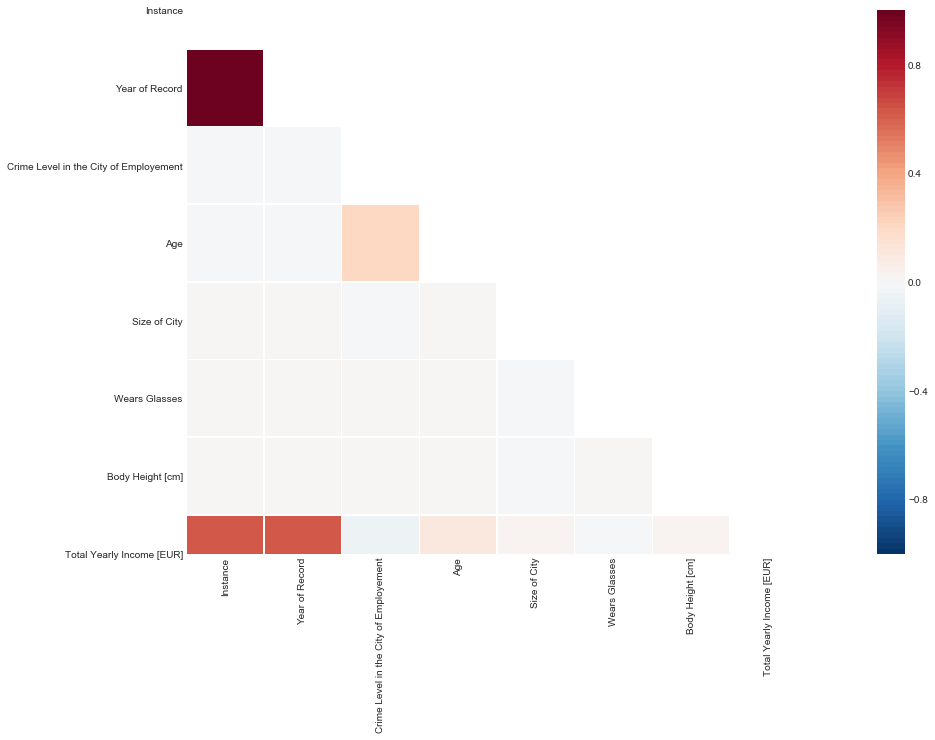

In [9]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(25,10)) 
 
plt.subplot(1,1, 1)
 
mask = np.zeros_like(train.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(train.corr(), 
            vmin=-1, vmax=1, 
            square=True, 
            cmap=sns.color_palette("RdBu_r", 100), 
            mask=mask, 
            linewidths=.5);

In [10]:
#构造等级特征
data['Satisfation with employer'] = data['Satisfation with employer'].map \
     ({'Average':2, 'Happy':4, 'Somewhat Happy':3, 'Unhappy':1})

In [11]:
data.isnull().any()

Instance                                                    False
Year of Record                                              False
Housing Situation                                           False
Crime Level in the City of Employement                      False
Work Experience in Current Job [years]                      False
Satisfation with employer                                   False
Gender                                                      False
Age                                                         False
Country                                                     False
Size of City                                                False
Profession                                                  False
University Degree                                           False
Wears Glasses                                               False
Body Height [cm]                                            False
Yearly Income in addition to Salary (e.g. Rental Income)    False
Total Year

In [12]:
#对于每个country和profession特征，用其特征值下收入均值来替换
country_income = dict(train.groupby('Country').mean()['Total Yearly Income [EUR]']/10000)
data.Country = data.Country.map(country_income)
data.Country = data.Country.fillna(data.Country.mean())
country_income = dict(train.groupby('Profession').mean()['Total Yearly Income [EUR]']/10000)
data.Profession = data.Profession.map(country_income)
country_income = dict(train.groupby('Profession').mean()['Total Yearly Income [EUR]']/10000)
data.Profession = data.Profession.map(country_income)

#前面的254287数据用来构造均值特征
sp = 254287

In [13]:
#转换成数值
data.iloc[:,-2] = data.iloc[:,-2].map(lambda x: float(x[:-3]))

In [14]:
data.head()

,Instance,Year of Record,Housing Situation,Crime Level in the City of Employement,Work Experience in Current Job [years],Satisfation with employer,Gender,Age,Country,Size of City,Profession,University Degree,Wears Glasses,Body Height [cm],Yearly Income in addition to Salary (e.g. Rental Income),Total Yearly Income [EUR]
0,855498,2009.0,Large Apartment,114,20,2,other,43,5.523336,82491,NaN,Master,1,171,61899.39,230073.37
1,391143,1971.0,Large House,95,10,2,male,14,5.485698,91463,NaN,Bachelor,0,187,0.00,920.18
2,498472,1980.0,Large House,26,16,2,male,36,21.552767,1125454,NaN,Master,1,140,0.00,128802.16
3,230928,1958.0,0,43,11,4,female,27,5.439411,305751,NaN,Bachelor,1,158,0.00,2337.02
4,507472,1981.0,Medium House,6,21,2,male,49,5.613572,16297,NaN,No,0,152,0.00,5572.97


In [15]:
cats = ['Year of Record', 'Housing Situation','Country','Size of City',
        'Crime Level in the City of Employement','Work Experience in Current Job [years]']
cons = ['Satisfation with employer','Gender','Age',
       'University Degree','Body Height [cm]','Profession']
data['Work Experience in Current Job [years]'] = data['Work Experience in Current Job [years]'].astype(str)

In [16]:
#This is the inspiration I got from the best code. 
#I modified with constructed mean features, cross mean features

def create_feature(df,cats,cons,normalize=True):
    for cat in cats:
        value = df[cat].value_counts(dropna=False, normalize=normalize).to_dict()
        num = cat + '_FE_FULL'
        df[num + num] = df[cat].map(value)
        #构造均值特征mean features
        df[num] = df[cat].map( dict(df.iloc[:sp].groupby(cat).mean()['Total Yearly Income [EUR]']/10000))
        df[num] = df[num].fillna(df[num].mean())
        df[num] = df[num].astype('float32')
        for con in cons:
            new_col = cat +'_'+ con
            df[new_col] = df[cat].astype(str)+'_'+df[con].astype(str)
            temp_df = df[new_col]
            fq_encode = temp_df.value_counts(normalize=True).to_dict()
            #构造交叉均值特征cross mean features
            df[new_col] = df[new_col].map( dict(df.iloc[:sp+1].groupby( \
                               new_col).mean()['Total Yearly Income [EUR]']/10000))
            df[new_col] = df[new_col].fillna(df[new_col].mean())
    return df

data = create_feature(data,cats,cons)
data['Work Experience in Current Job [years]'] = data['Work Experience in Current Job [years]' \
                                                     ].replace('#NUM!', data.iloc[:, -1].mean()).astype(float)

#构造类别特征 Category Characteristics
for col in data.dtypes[data.dtypes == 'object'].index.tolist():
    feat_le = LabelEncoder()
    feat_le.fit(data[col].unique().astype(str))
    data[col] = feat_le.transform(data[col].astype(str))

del_col = set(['Total Yearly Income [EUR]','Instance'])
features_col =  list(set(data) - del_col)
features_col

['University Degree',
 'Year of Record_FE_FULLYear of Record_FE_FULL',
 'Year of Record_FE_FULL',
 'Housing Situation_FE_FULLHousing Situation_FE_FULL',
 'Country_Body Height [cm]',
 'Work Experience in Current Job [years]_Satisfation with employer',
 'Crime Level in the City of Employement_Satisfation with employer',
 'Gender',
 'Crime Level in the City of Employement_Profession',
 'Size of City_Satisfation with employer',
 'Housing Situation',
 'Size of City_FE_FULL',
 'Size of City_FE_FULLSize of City_FE_FULL',
 'Crime Level in the City of Employement_Body Height [cm]',
 'Age',
 'Year of Record_Age',
 'Year of Record_University Degree',
 'Size of City',
 'Size of City_Age',
 'Year of Record_Satisfation with employer',
 'Year of Record',
 'Work Experience in Current Job [years]_FE_FULL',
 'Housing Situation_Age',
 'Country_Gender',
 'Work Experience in Current Job [years]_Body Height [cm]',
 'Year of Record_Profession',
 'Crime Level in the City of Employement_Gender',
 'Country_FE_F

In [17]:
data.head()

,Instance,Year of Record,Housing Situation,Crime Level in the City of Employement,Work Experience in Current Job [years],Satisfation with employer,Gender,Age,Country,Size of City,...,Crime Level in the City of Employement_Body Height [cm],Crime Level in the City of Employement_Profession,Work Experience in Current Job [years]_FE_FULLWork Experience in Current Job [years]_FE_FULL,Work Experience in Current Job [years]_FE_FULL,Work Experience in Current Job [years]_Satisfation with employer,Work Experience in Current Job [years]_Gender,Work Experience in Current Job [years]_Age,Work Experience in Current Job [years]_University Degree,Work Experience in Current Job [years]_Body Height [cm],Work Experience in Current Job [years]_Profession
0,855498,2009.0,2,114,20.0,2,3,43,5.523336,82491,...,4.397214,5.793232,0.015639,10.015439,9.144765,10.937183,10.128232,11.042232,9.361396,10.015439
1,391143,1971.0,3,95,10.0,2,2,14,5.485698,91463,...,6.338174,7.018596,0.043718,4.434315,4.139788,4.563008,3.814549,4.300925,4.021657,4.434315
2,498472,1980.0,3,26,16.0,2,2,36,21.552767,1125454,...,6.044283,7.655859,0.021084,9.247430,8.676331,9.111448,9.554199,10.613012,13.859558,9.247429
3,230928,1958.0,0,43,11.0,4,1,27,5.439411,305751,...,8.783416,7.363873,0.047811,4.743308,4.644353,4.709329,4.564130,4.618321,4.437977,4.743308
4,507472,1981.0,5,6,21.0,2,2,49,5.613572,16297,...,6.970191,9.828241,0.027624,6.230939,5.900624,6.079544,5.791216,5.285314,7.926977,6.230939


In [18]:
# def PCA(X, topNfeat=9999999):
#     # 1.原始数据默认都是每一行为一个样本数据，每一列为一个特征，
#     #   所以进行转置，让每一列代表一个样本数据
#     X = np.array(X)
#     X = np.transpose(X)
#     # 2.将数据的每一行（代表一个属性字段）进行零均值化
#     meanValues = np.mean（X, axis=1) #计算每一行的均值
#     meanValues = np.transepose(np.mat(meanValues)) #将一个向量转换成n*1的矩阵
#     meanRemoved = X - meanValues   #均值归零
    
#     #3.求出协方差矩阵
#     covMat = np.cov(meanRemoved) #cov计算协方差时除的是 （样本个数-1）,也就是自由度
# #     covMat =  meanRemoved @ meanRemoved.T / (meanRemoved.shape[1])
#     print("协方差矩阵：\n",covMat)
    
#     #4求出协方差矩阵的特征值及对应的特征向量
#     eigVals, eigVects = np.linalg.eig(covMat)  #eigVals:特征值  eigVects：特征向量
#     print("特征值\n",eigVals)
#     print("特征向量\n",eigVects)
    
#     #5将特征向量按对应特征值大小从左到右按列排列成矩阵，取前k列组成矩阵
#     # argsort函数返回的是数组值从小到大的索引值,参数中加个-号，变为从大到小
#     eigValInd = np.argsort(-eigVals)
#     eigValInd = eigValInd[0:topNfeat]  #取出前topNfeat个最大的特征值所对应的索引
#     redEigVects = eigVects[:,eigValInd]  #redEigVects 即为需要的变换矩阵，即P
#     print("变换矩阵：\n",redEigVects)
    
#     #6 Y=P^TX即为降维到k维后的数据
#     X_PCA = np.transpose(redEigVects) @ X
#     return X_PCA

# pca = PCA(0.95)
# pca.fit(np.int(X_train))
# X_train= pca.transform(X_train)
# X_test = pca.transform(X_test)

In [19]:
from sklearn.ensemble import RandomForestRegressor

param = {'num_trees':20000, 
         'max_depth': 21, 
         'objective':'regression', 
         "verbosity": -1,
         'metric': 'mae',
         'bagging_fraction': 0.8, 
         'learning_rate': 0.01,}
X_train,X_test  = data[features_col].iloc[:1048513],data[features_col].iloc[1048514 :]
Y_train = data['Total Yearly Income [EUR]'].iloc[:1048513]
x_train,x_val,y_train,y_val = X_train.iloc[sp+1: ,:],  X_train.iloc[:sp,:],  \
                    Y_train.iloc[sp+1: ],  Y_train.iloc[:sp ]
train_data = lgb.Dataset(x_train, label=y_train, feature_name='auto')#categorical_feature=cat
val_data = lgb.Dataset(x_val, label=y_val, feature_name='auto')

bst = lgb.train(param, train_data, 20000, verbose_eval = 100, valid_sets=[val_data])

/Applications/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's l1: 31676.7
[200]	valid_0's l1: 18543.1
[300]	valid_0's l1: 13928.2
[400]	valid_0's l1: 12099.6
[500]	valid_0's l1: 11260.1
[600]	valid_0's l1: 10828.5
[700]	valid_0's l1: 10560.1
[800]	valid_0's l1: 10366.2
[900]	valid_0's l1: 10204.8
[1000]	valid_0's l1: 10037.9
[1100]	valid_0's l1: 9911.82
[1200]	valid_0's l1: 9802.86
[1300]	valid_0's l1: 9702.03
[1400]	valid_0's l1: 9619.52
[1500]	valid_0's l1: 9545.39
[1600]	valid_0's l1: 9465.18
[1700]	valid_0's l1: 9397.65
[1800]	valid_0's l1: 9342.72
[1900]	valid_0's l1: 9294.83
[2000]	valid_0's l1: 9254.62
[2100]	valid_0's l1: 9215.91
[2200]	valid_0's l1: 9181.4
[2300]	valid_0's l1: 9148.13
[2400]	valid_0's l1: 9117.94
[2500]	valid_0's l1: 9092.77
[2600]	valid_0's l1: 9067.08
[2700]	valid_0's l1: 9046.65
[2800]	valid_0's l1: 9028.84
[2900]	valid_0's l1: 9013.28
[3000]	valid_0's l1: 8993.32
[3100]	valid_0's l1: 8973.99
[3200]	valid_0's l1: 8954.75
[3300]	valid_0's l1: 8935.6
[3400]	valid_0's l1: 8918.84
[3500]	valid_0's l1: 8904

In [20]:
from sklearn.metrics import mean_absolute_error
predict = bst.predict(x_val)
val_mae = mean_absolute_error(y_val,predict)
val_mae

8154.943774223993

In [21]:
#生成结果
#rfr.fit(X_train, Y_train)
predict = bst.predict(X_test)
result=pd.DataFrame([range(1,1+len(predict)), predict]).T
result.columns = ['Instance', 'Total Yearly Income [EUR]']
result.to_csv("sub191126_4.csv",index=False)
result.head()

,Instance,Total Yearly Income [EUR]
0,1.0,40928.494857
1,2.0,7229.881722
2,3.0,2813.592355
3,4.0,86974.140862
4,5.0,4132.944818
